In [81]:
import importlib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

# import model.Portfolio as Portfolio
# import model.Optimizer as Optimizer
# importlib.reload(Portfolio)
# importlib.reload(Optimizer)
from model.Portfolio import Portfolio
from model.Optimizer import Optimizer

In [63]:
names = ["VUSA", "A35", "S59", "VUSD", "BAB", "IWDA", "Z74", "ES3", "VWRD"]

p = Portfolio()
p.rf = 0.02

# Add all assets
for name in names:
    p.addAsset(f"data/{name}.csv", name)

# Convert non SGD assets to SGD
p.addExchangeRate("data/forex/SGDEUR.csv", "EUR", True)
p.addExchangeRate("data/forex/USDSGD.csv", "USD", False)
p.exchangeAdjustment(0, "EUR")
p.exchangeAdjustment(3, "USD")
p.exchangeAdjustment(4, "USD")
p.exchangeAdjustment(5, "USD")
p.exchangeAdjustment(8, "USD")

In [64]:
o = Optimizer(p)
weight, tests = o.kfold(5)

In [65]:
weight

[0.15475892125470264,
 0.20547924399206283,
 9.482548858319044e-13,
 8.960370051426765e-14,
 0.4801464697188137,
 0.032286985065754975,
 0.024513084545404733,
 0.10281529542266218,
 3.19884065758836e-13]

In [66]:
tests

{'sharpeRaw': [6.004114351586114,
  15.353049241859265,
  10.16217894507588,
  -13.433417895991601,
  36.510767217319135],
 'sharpeAvg': 10.919338371969758,
 'sharpeStd': 16.077117141075874,
 'weightsRaw': [array([1.11900024e-01, 2.61356927e-01, 4.65666788e-12, 0.00000000e+00,
         4.68025414e-01, 4.58947912e-02, 1.46746263e-02, 9.81482178e-02,
         1.36425983e-12]),
  array([1.55168613e-01, 2.32821707e-01, 0.00000000e+00, 4.48018503e-13,
         4.39346427e-01, 1.80211094e-02, 1.25528025e-13, 1.54642144e-01,
         0.00000000e+00]),
  array([0.19114357, 0.17143652, 0.        , 0.        , 0.51451099,
         0.        , 0.03906419, 0.08384474, 0.        ]),
  array([1.38628202e-01, 1.89591090e-01, 0.00000000e+00, 0.00000000e+00,
         5.02131724e-01, 7.76083150e-02, 6.88266094e-02, 2.32140601e-02,
         1.30197109e-13]),
  array([1.76954201e-01, 1.72189977e-01, 8.46065483e-14, 0.00000000e+00,
         4.76717797e-01, 1.99107097e-02, 0.00000000e+00, 1.54227315e-01,
  

In [ ]:
result, plot = p.backtest(weight)

In [68]:
result

{'dateStart': Timestamp('2013-06-05 00:00:00'),
 'dateEnd': Timestamp('2019-06-13 00:00:00'),
 'days': 2199,
 'valueStart': 100000.0,
 'valueEnd': 146532.57716551426,
 'sharpe': 0.7515747624605625,
 'drawdown': 0.0,
 'drawdownPeriod': 0,
 'moneydown': 0.0,
 'maxDrawdown': 4.935560437033693,
 'maxDrawdownPeriod': 248,
 'maxMoneydown': 6256.930259689281,
 'averageReturns': 0.057232148370835755,
 'standardDeviation': 0.04953884860228981,
 'positiveYears': 7,
 'negativeYears': 0,
 'noChangeYears': 0,
 'bestYearReturns': 0.15900549707538514,
 'worstYearReturns': 0.0010410745158344614}

<IPython.core.display.Javascript object>


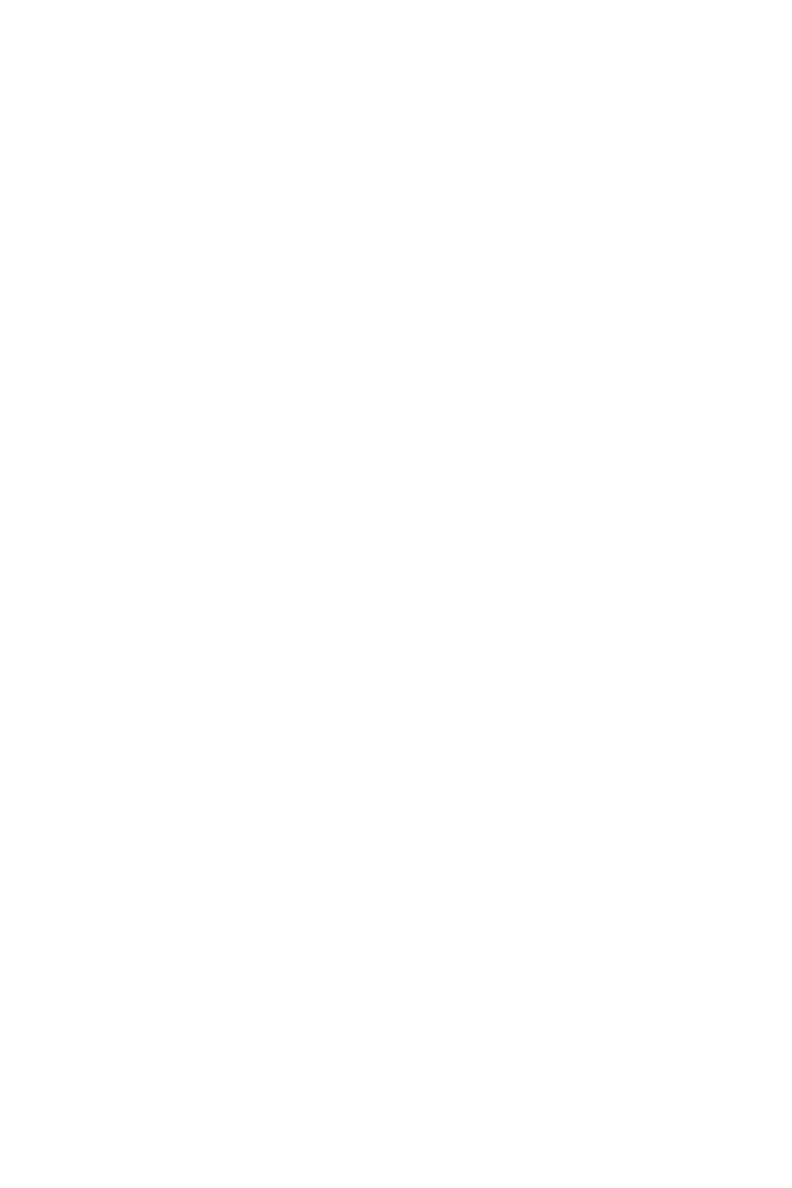

[[<Figure size 720x1080 with 12 Axes>]]

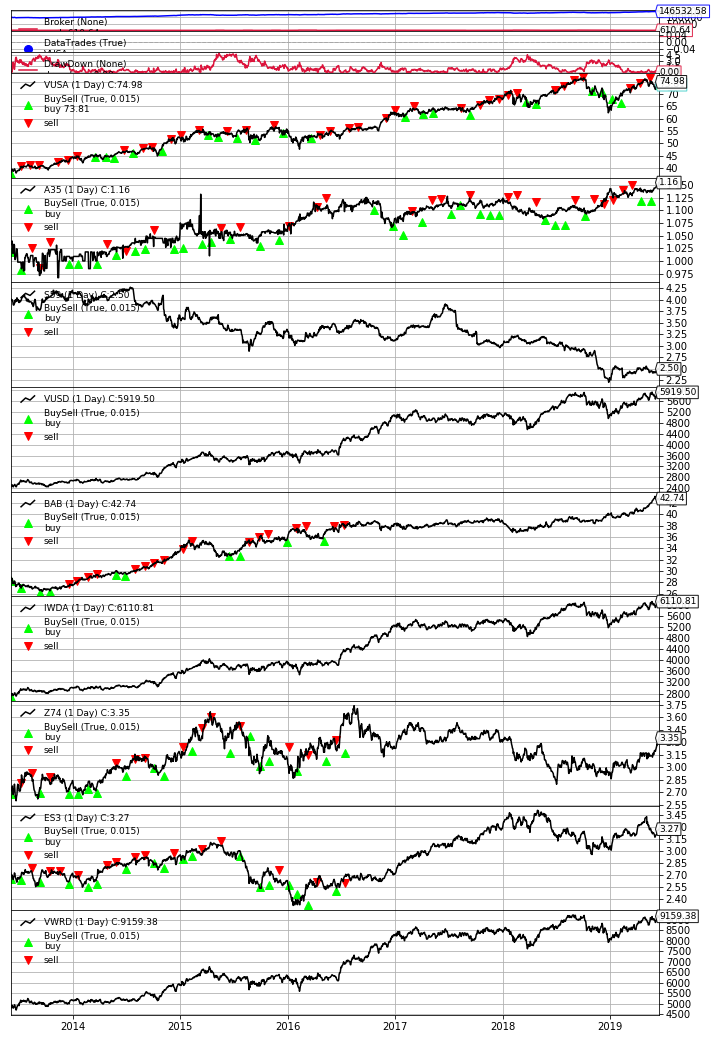

In [131]:
plt.rcParams["figure.figsize"] = 10, 15
plot()

## Next Step

- Timeseries K-fold validation when generating weights
    - Monte carlo on K-1 segments of data
    - Test result on 1 segment of data
- Genetics algorithm
- Add backtest capabilities
    - Report over the entire period
    - Custom period

## Even More Advanced Shits

- Selective optimisation for time period (ie interest rate hike, financial crisis, etc)

In [ ]:
- Test a strategy against different time periods (best if notable)
- Show covariance of stocks